In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import keras.layers as layers

import torch
import torch.nn as nn
from torch.nn.utils import weight_norm

from tqdm import tqdm
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from create_data_set import clean_data

2023-08-08 14:26:15.806419: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/hadasabraham/miniconda3/envs/nanopore/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data pre-process

In [2]:
f_name  = f'/home/hadasabraham/SignalCluster/data/datasets/hadas_adir_barak_train.csv'
# create_data_set(f_name, 20, 2, False)
col_names = ['signal', 'barcode']
data = pd.read_csv(f_name, index_col=0)
# data.columns = col_names
X = data['signal']
X = X.apply(eval).apply(np.array)
X = X.apply(lambda x: clean_data(x,3000))
Y = data['barcode']
y_signals = list(Y)
y_signals2 = list(set(y_signals))
# Example names vector (should have 20 names)
class_number = [i for i in range(20)]

seed = 211

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=seed)

# seprate to test, validation 
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.33, random_state=seed)
print(f"Train size: {x_train.shape[0]}")
print(f"Val size: {x_val.shape[0]}")
print(f"Test size: {x_test.shape[0]}")
y_train_np = np.array([class_number[y_signals2.index(x)] for x in y_train]).astype(np.int)
y_test_np = np.array([class_number[y_signals2.index(x)] for x in y_test]).astype(np.int)
y_val_np = np.array([class_number[y_signals2.index(x)] for x in y_val]).astype(np.int)
# Convert the NumPy arrays to torch tensors
x_train_tensor = torch.tensor(np.stack(x_train))
y_train_tensor = torch.from_numpy(y_train_np)

x_val_tensor = torch.tensor(np.stack(x_val))
y_val_tensor = torch.from_numpy(y_val_np)
x_test_tensor = torch.tensor(np.stack(x_test))
y_test_tensor = torch.from_numpy(y_test_np)

Train size: 4172
Val size: 591
Test size: 1197


/tmp/ipykernel_3358785/302632302.py:24: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_train_np = np.array([class_number[y_signals2.index(x)] for x in y_train]).astype(np.int)
/tmp/ipykernel_3358785/302632302.py:25: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release not

### plot data

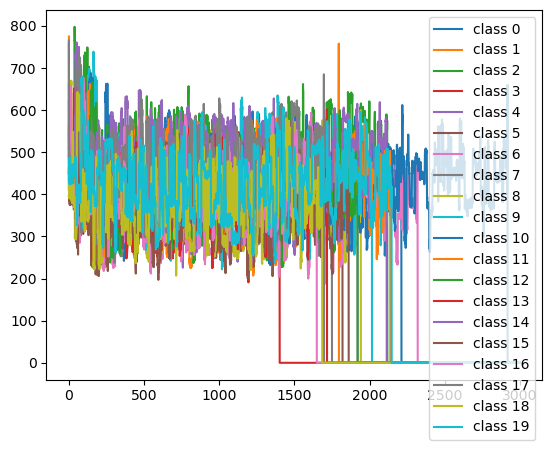

In [3]:
plt.figure()
for c in class_number:
    c_x_train = x_train_tensor[y_train_tensor == c]
    plt.plot(c_x_train[0], label="class " + str(c))
plt.legend(loc="best")
plt.show()
plt.close()

### Data shpaes

In [3]:
x_train_tensor = x_train_tensor.reshape((x_train_tensor.shape[0], 1, x_train_tensor.shape[1]))
x_test_tensor = x_test_tensor.reshape((x_test_tensor.shape[0], 1, x_test_tensor.shape[1]))
print(x_train_tensor.shape[0])
print(x_train_tensor.shape[1])
print(x_train_tensor.shape[2])
print(type(x_train_tensor))
print(type(y_train_tensor))
x_train_tensor.shape[1:]
print(type(y_train_tensor[0]))
print(y_train_tensor[0])

4172
1
3000
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
tensor(11)


### Model

In [4]:


class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [5]:
# class TCN(nn.Module):
#     def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
#         super(TCN, self).__init__()
#         self.tcn = TemporalConvNet(input_size, num_channels, kernel_size=kernel_size, dropout=dropout)
#         self.transformer = torch.nn.Transformer(d_model=512, nhead=8, num_encoder_layers=6, num_decoder_layers=6, dim_feedforward=2048, dropout=0.1, activation='relu', custom_encoder=None, custom_decoder=None, layer_norm_eps=1e-05, batch_first=False, norm_first=False, device=None, dtype=None)
#         self.linear = nn.Linear(num_channels[-1], output_size)
class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
        super(TCN, self).__init__()
        self.tcn = TemporalConvNet(input_size, num_channels, kernel_size=kernel_size, dropout=dropout)
        self.linear = nn.Linear(num_channels[-1], output_size)

    def forward(self, inputs):
        """Inputs have to have dimension (N, C_in, L_in)"""
        y1 = self.tcn(inputs)  # input should have dimension (N, C, L)
        o = self.linear(y1[:, :, -1])
        return nn.Sigmoid(o)

In [6]:
num_classes = 20
dropout = 0.1
kernel_size = 50
'number of hidden units per layer (default: 25)'
nhids = 25
'# of levels (default: 8)'
levels = 8
channel_sizes = [nhids] * levels
input_channels = 1

In [7]:
batch_size = 32
learning_rate = 1e-4
epochs = 20

In [8]:
# device - cpu or gpu?
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# loss criterion
criterion = nn.CrossEntropyLoss()

# build our model and send it to the device
model = TCN(input_size = input_channels, output_size = num_classes, num_channels = channel_sizes, kernel_size = kernel_size, dropout = dropout).to(device) # no need for parameters as we alredy defined them in the class

# optimizer - SGD, Adam, RMSProp...
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
from torch.utils.data import Dataset, DataLoader
# Define custom Dataset for the training data
class MyDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, index):
        x = self.x_data[index]
        y = self.y_data[index]
        return x, y

In [10]:
# Create separate datasets for training data and labels
train_dataset = MyDataset(x_train_tensor, y_train_tensor)
test_dataset = MyDataset(x_test_tensor, y_test_tensor)

# dataloaders - creating batches and shuffling the data
trainloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [14]:
dataiter = iter(trainloader)
signals, labels = dataiter.next()
print(signals.shape)

torch.Size([32, 1, 3000])


In [15]:
print(type(signals))
print(type(signals[2]))


<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [11]:
# function to calcualte accuracy of the model
def calculate_accuracy(model, dataloader, device):
    model.eval() # put in evaluation mode,  turn of DropOut, BatchNorm uses learned statistics
    total_correct = 0
    total_signals = 0
    confusion_matrix = np.zeros([20,20], int)
    with torch.no_grad():
        for data in dataloader:
            signals, labels = data
            signals = signals.to(device)
            labels = labels.to(device)
            outputs = model(signals)
            _, predicted = torch.max(outputs.data, 1)
            total_signals += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            for i, l in enumerate(labels):
                confusion_matrix[l.item(), predicted[i].item()] += 1 

    model_accuracy = total_correct / total_signals * 100
    return model_accuracy, confusion_matrix

In [12]:
import time

# training loop
for epoch in range(1, epochs + 1):
    model.train()  # put in training mode, turn on DropOut, BatchNorm uses batch's statistics
    running_loss = 0.0
    epoch_time = time.time()
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        # send them to device
        inputs = inputs.to(device)
        labels = labels.to(device)
        # augmentation with `kornia` happens here inputs = aug_list(inputs)

        # forward + backward + optimize
        outputs = model(inputs)  # forward pass
        loss = criterion(outputs, labels)  # calculate the loss
        # always the same 3 steps
        optimizer.zero_grad()  # zero the parameter gradients
        loss.backward()  # backpropagation
        optimizer.step()  # update parameters

        # print statistics
        running_loss += loss.data.item()

    # Normalizing the loss by the total number of train batches
    running_loss /= len(trainloader)

    # Calculate training/test set accuracy of the existing model
    train_accuracy, _ = calculate_accuracy(model, trainloader, device)
    test_accuracy, _ = calculate_accuracy(model, testloader, device)

    log = "Epoch: {} | Loss: {:.4f} | Training accuracy: {:.3f}% | Test accuracy: {:.3f}% | ".format(epoch, running_loss, train_accuracy, test_accuracy)
    # with f-strings
    # log = f"Epoch: {epoch} | Loss: {running_loss:.4f} | Training accuracy: {train_accuracy:.3f}% | Test accuracy: {test_accuracy:.3f}% |"
    epoch_time = time.time() - epoch_time
    log += "Epoch Time: {:.2f} secs".format(epoch_time)
    # with f-strings
    # log += f"Epoch Time: {epoch_time:.2f} secs"
    print(log)
    
    # # save model
    # if epoch % 20 == 0:
    #     print('==> Saving model ...')
    #     state = {
    #         'net': model.state_dict(),
    #         'epoch': epoch,
    #     }
    #     if not os.path.isdir('checkpoints'):
    #         os.mkdir('checkpoints')
    #     torch.save(state, './checkpoints/cifar_cnn_ckpt.pth')

print('==> Finished Training ...')

RuntimeError: expected scalar type Long but found Float

### Test

In [ ]:
# load model, calculate accuracy and confusion matrix
model = TCN().to(device)
state = torch.load('./checkpoints/cifar_cnn_ckpt.pth', map_location=device)
model.load_state_dict(state['net'])
# note: `map_location` is necessary if you trained on the GPU and want to run inference on the CPU

test_accuracy, confusion_matrix = calculate_accuracy(model, testloader, device)
print("test accuracy: {:.3f}%".format(test_accuracy))

# plot confusion matrix
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()